# Latent Space Exploration Prototype

In [ ]:
# cloning the stylegan repo
!git clone https://github.com/NVlabs/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 127, done.
remote: Total 127 (delta 0), reused 0 (delta 0), pack-reused 127
Receiving objects: 100% (127/127), 591.89 KiB | 8.00 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
# verify its cloned the contents
!ls /content/stylegan2/

dataset_tool.py  LICENSE.txt		 README.md	   run_training.py
dnnlib		 metrics		 run_generator.py  test_nvcc.cu
Dockerfile	 pretrained_networks.py  run_metrics.py    training
docs		 projector.py		 run_projector.py


In [ ]:
import sys
sys.path.insert(0, "/content/stylegan2")


%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

import os
import pickle
import argparse
import numpy as np
import pandas as pd

# Python imaging library, https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.new
from PIL import Image
#from PIL.Image import Image as PilImage
import PIL

# Deep Neural Network based library
import dnnlib
import dnnlib.tflib as tflib
import re


TensorFlow 1.x selected.
1.15.2


# 0) Generator Definitions

These are the definitions for:


*   Seeding latent space vectors 
*   Generate images to path


*   Matrix transformations
*   List item




In [ ]:
# Creates an array of size and populates with a random number from a state
def seeder(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) )  # fills the seed with an array of #filled with random floats sampled from a univariate “normal” (Gaussian) distribution of mean 0 and variance 1
  return result

## Optional style mixing example

In [ ]:
def style_mixing_example(network_pkl, row_seeds, col_seeds, truncation_psi, col_styles, minibatch_size=4):
    print('Loading networks from "%s"...' % network_pkl)
    _G, _D, Gs = pretrained_networks.load_networks(network_pkl)
    w_avg = Gs.get_var('dlatent_avg') # [component]

    Gs_syn_kwargs = dnnlib.EasyDict()
    Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_syn_kwargs.randomize_noise = False
    Gs_syn_kwargs.minibatch_size = minibatch_size

    print('Generating W vectors...')
    all_seeds = list(set(row_seeds + col_seeds))
    all_z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in all_seeds]) # [minibatch, component]
    all_w = Gs.components.mapping.run(all_z, None) # [minibatch, layer, component]
    all_w = w_avg + (all_w - w_avg) * truncation_psi # [minibatch, layer, component]
    w_dict = {seed: w for seed, w in zip(all_seeds, list(all_w))} # [layer, component]

    print('Generating images...')
    all_images = Gs.components.synthesis.run(all_w, **Gs_syn_kwargs) # [minibatch, height, width, channel]
    image_dict = {(seed, seed): image for seed, image in zip(all_seeds, list(all_images))}

    print('Generating style-mixed images...')
    for row_seed in row_seeds:
        for col_seed in col_seeds:
            w = w_dict[row_seed].copy()
            w[col_styles] = w_dict[col_seed][col_styles]
            image = Gs.components.synthesis.run(w[np.newaxis], **Gs_syn_kwargs)[0]
            image_dict[(row_seed, col_seed)] = image

    print('Saving images...')
    for (row_seed, col_seed), image in image_dict.items():
        PIL.Image.fromarray(image, 'RGB').save(dnnlib.make_run_dir_path('%d-%d.png' % (row_seed, col_seed)))

    print('Saving image grid...')
    _N, _C, H, W = Gs.output_shape
    canvas = PIL.Image.new('RGB', (W * (len(col_seeds) + 1), H * (len(row_seeds) + 1)), 'black')
    for row_idx, row_seed in enumerate([None] + row_seeds):
        for col_idx, col_seed in enumerate([None] + col_seeds):
            if row_seed is None and col_seed is None:
                continue
            key = (row_seed, col_seed)
            if row_seed is None:
                key = (col_seed, col_seed)
            if col_seed is None:
                key = (row_seed, row_seed)
            canvas.paste(PIL.Image.fromarray(image_dict[key], 'RGB'), (W * col_idx, H * row_idx))
    canvas.save(dnnlib.make_run_dir_path('grid.png'))

In [ ]:
# Function for generating images from a pretrained network given a set of seeds
def generate_images(Gs, seeds, truncation_psi):
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() \
                  if name.startswith('noise')]

    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if truncation_psi is not None:
        Gs_kwargs.truncation_psi = truncation_psi

    # Generate the images from the seed
    for seed_idx, seed in enumerate(seeds):
        print('Generating image for seed %d/%d ...' % (seed_idx, len(seeds)))
        rnd = np.random.RandomState()
        
        # Define the generated image shape
        tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        
        # Createrun the network for the given NumPy arrays(s) , and return the output(s) as NumPy array(s).
        images = Gs.run(seed, None, **Gs_kwargs) # [minibatch, height, width, channel]

        path = f"/content/out/image{seed_idx}.png" # creates an output path with seed
        PIL.Image.fromarray(images[0], 'RGB').save(path)# creates a PIL image from the generated image data then save to path



# Function for generating images the pretrained network given a set of seeds 
def generate_images_to_path(Gs, seeds, truncation_psi, out_path):
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() \
                  if name.startswith('noise')]

    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if truncation_psi is not None:
        Gs_kwargs.truncation_psi = truncation_psi

    # Generate the images from the seed
    for seed_idx, seed in enumerate(seeds):
        print('Generating image for seed %d/%d ...' % (seed_idx, len(seeds)))
        rnd = np.random.RandomState()
        
        # define the generated image shape
        tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        
        # Createrun the network for the given NumPy arrays(s) , and return the output(s) as NumPy array(s).
        images = Gs.run(seed, None, **Gs_kwargs) # [minibatch, height, width, channel]
        
        # create outpath if none
        if os.path.exists(out_path) != True:
          os.makedirs(out_path) # TODO: change this to a drive path 

        path = f"{out_path}/{seed_idx}.png" # creates an output path with seed
        PIL.Image.fromarray(images[0], 'RGB').save(path)# creates a PIL image from the generated image data then save to path


## Define Generator Functions

# 1) Load Model From Drive

Load the pretrained model in from google drive or content.
Mount dirve

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

NETWORK_DIR = '/content/drive/MyDrive/DeepLearning/'

Mounted at /content/drive


In [ ]:
# Init tf
tflib.init_tf()

# Load the Model From path in drive
model_data_path = "/content/drive/MyDrive/DeepLearning/"


# model_str = 'network-snapshot-026392.pkl'
# model_str = 'textures.pkl'           
# model_str = 'trypophobia.pkl'
model_str = 'Long_Krrrl_Drawings__final.pkl'

with open(NETWORK_DIR + model_str,'rb') as f:
  _G, _D, Gs = pickle.load(f)

# _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
# _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
# Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

Gs.print_layers()
_D.print_layers()

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.

Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/latents_in            -         (?, 512)             -               
G_mapping/labels_in             -         (?, 0)               -               
G_mapping/Normalize             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping

## Generating a single image from a seed

Example of generating an image form a single seed.

In [ ]:
# Pick latent vector. (can put in a number)
rnd = np.random.RandomState(5)

latents = rnd.randn(1, Gs.input_shape[1])

# Generate image
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)

# Save image
save_path = '/content/out'
if os.path.exists(save_path) != True:
   os.makedirs(save_path) # TODO: change this to a drive path 

png_filename = os.path.join(f'{save_path}/example1.png')
PIL.Image.fromarray(images[0], 'RGB').save(png_filename)

# 2) Generate a series of random seeds

## Generate a set of random seeds

In [ ]:
# Define a submit config
sc = dnnlib.SubmitConfig()
sc.num_gpus = 1
sc.submit_target = dnnlib.SubmitTarget.LOCAL
sc.local.do_not_copy_source_files = True
sc.run_dir_root = "/content"#/drive/My Drive/projects/stylegan2"
sc.run_desc = 'generate-images'

vector_size = Gs.input_shape[1:][0] # assign the input shape in the Gs generic network abstraction

# Define seeds
seeds = seeder( range(8000,8100), vector_size)

# Generate the images for range of 50
outpath = f'{NETWORK_DIR}seed_images'

#if os.path.exists(outpath) != True:
        #os.makedirs(outpath) # TODO: change this to a drive path 
generate_images_to_path(Gs, seeds, truncation_psi=0.5, out_path=outpath)

Generating image for seed 0/100 ...
Generating image for seed 1/100 ...
Generating image for seed 2/100 ...
Generating image for seed 3/100 ...
Generating image for seed 4/100 ...
Generating image for seed 5/100 ...
Generating image for seed 6/100 ...
Generating image for seed 7/100 ...
Generating image for seed 8/100 ...
Generating image for seed 9/100 ...
Generating image for seed 10/100 ...
Generating image for seed 11/100 ...
Generating image for seed 12/100 ...
Generating image for seed 13/100 ...
Generating image for seed 14/100 ...
Generating image for seed 15/100 ...
Generating image for seed 16/100 ...
Generating image for seed 17/100 ...
Generating image for seed 18/100 ...
Generating image for seed 19/100 ...
Generating image for seed 20/100 ...
Generating image for seed 21/100 ...
Generating image for seed 22/100 ...
Generating image for seed 23/100 ...
Generating image for seed 24/100 ...
Generating image for seed 25/100 ...
Generating image for seed 26/100 ...
Generating 

In [ ]:
def GetRangeOfSeedImgs(dir_path, range):
  imgs = []

  for i in range:
    file_name = f'{i}.png'
    img = f'{img_to_plot}/1.png'
    img_PIL = Image.open(f"{img}")
    imgs.append(img_PIL)

  return imgs

Populating the interactive namespace from numpy and matplotlib


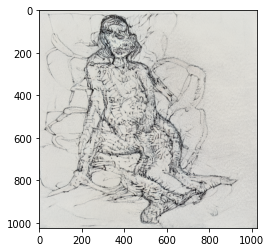

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img_to_plot = f'{NETWORK_DIR}seed_images'
img = mpimg.imread(f'{img_to_plot}/1.png')
label='First Line'
imgplot = plt.imshow(img,)

imgs = GetRangeOfSeedImgs(dir_path=img_to_plot,range=range(0,20))

#img_arr = numpy.array(imgs)

#display(imgs)

for i in range(0, 16):
  img = mpimg.imread(f'{img_to_plot}/{i}.png')
  #pyplot.subplot(img)
  
  #plt.show()


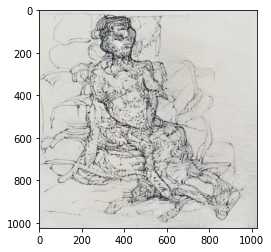

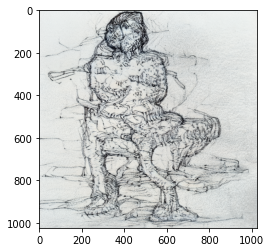

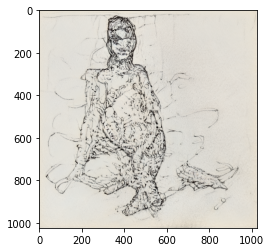

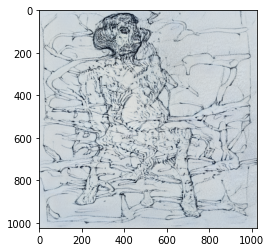

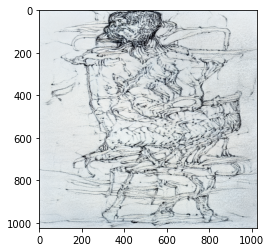

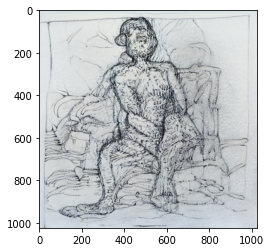

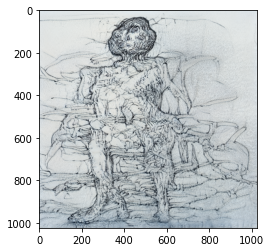

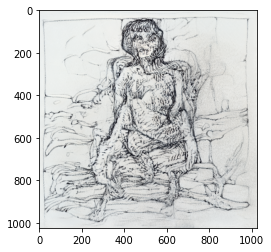

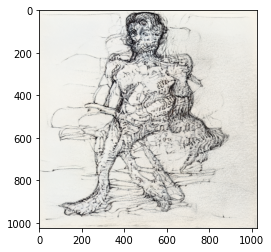

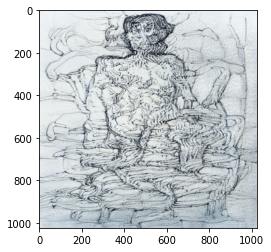

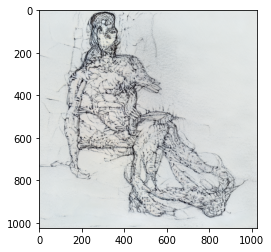

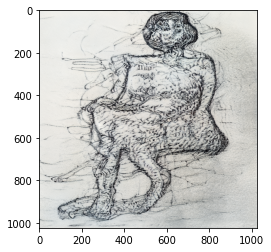

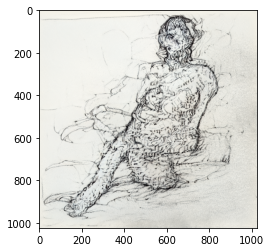

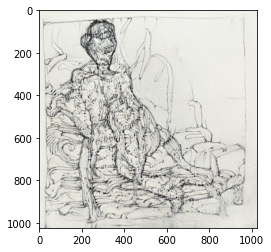

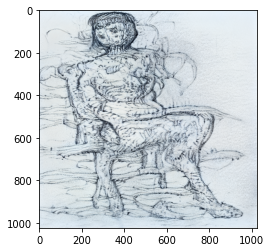

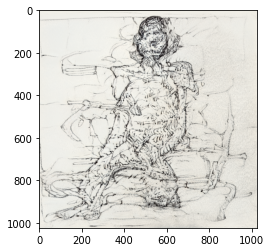

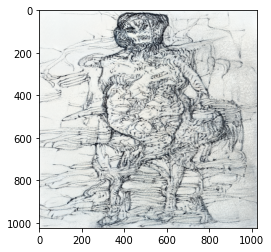

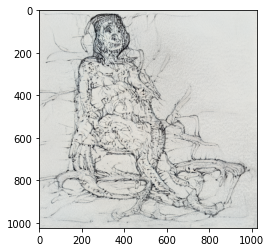

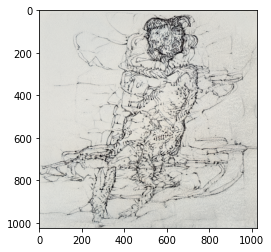

In [ ]:
# show first 20 images 

PIL.

for i in range(1,20):
  img_to_plot = f'{NETWORK_DIR}seed_images'
  img = mpimg.imread(f'{img_to_plot}/{i}.png')
  label=f'{i}.png'
  imgplot = plt.imshow(img,)
  plt.show() 

## Save the seeds as csv's to drive

In [ ]:
def save_seeds_to_path(seeds, path, file_name):

    for seed_idx, seed in enumerate(seeds):
      print('Generating csv for seed %d ...' % (seed_idx))
      # Create Directory if none
      if os.path.exists(path) != True:
        os.makedirs(path) # TODO: change this to a drive path 

      %cd path

      df = pd.DataFrame(seeds[seed_idx])
      csv_path = f"{path}/{file_name}{seed_idx}"
      df.to_csv(f'{csv_path}.csv', index = False, header = False)

In [ ]:
# save the image as seed to the path seeds
save_seeds_to_path(seeds = seeds, path = '/content/drive/MyDrive/DeepLearning/seed_csvs', file_name= 'seed')

Generating csv for seed 0 ...
[Errno 2] No such file or directory: 'path'
/content
Generating csv for seed 1 ...
[Errno 2] No such file or directory: 'path'
/content
Generating csv for seed 2 ...
[Errno 2] No such file or directory: 'path'
/content
Generating csv for seed 3 ...
[Errno 2] No such file or directory: 'path'
/content
Generating csv for seed 4 ...
[Errno 2] No such file or directory: 'path'
/content
Generating csv for seed 5 ...
[Errno 2] No such file or directory: 'path'
/content
Generating csv for seed 6 ...
[Errno 2] No such file or directory: 'path'
/content
Generating csv for seed 7 ...
[Errno 2] No such file or directory: 'path'
/content
Generating csv for seed 8 ...
[Errno 2] No such file or directory: 'path'
/content
Generating csv for seed 9 ...
[Errno 2] No such file or directory: 'path'
/content
Generating csv for seed 10 ...
[Errno 2] No such file or directory: 'path'
/content
Generating csv for seed 11 ...
[Errno 2] No such file or directory: 'path'
/content
Ge

100


## Load in the seed csv's from drive

In [ ]:
# Given an input index and a path containing seeds of the correct naming format, return a list of 512 float values
from csv import reader
def load_seed_in(path, idx):
  
  df = pd.read_csv(f'{path}/seed{idx}.csv')
  
  #print(f"{df}")
  in_values = df.columns.values.tolist()

  in_values_float = []

  for values in in_values:
    in_values_float.append(float(values))


  return in_values_float

In [ ]:
# Returns a list of seed datas
def load_seeds_in(path_in, seed_idx_list):
  values = []

  for i in range(len(seed_load_idx)):
    print(f'Loading seed {seed_load_idx [i]} from {seed_load_path}')
    seed = (load_seed_in(path=seed_load_path,idx=seed_load_idx[i]))
    values.append(np.array(seed))

  return values

## Flip Matrix function

As the seeds are loaded in from csv's they need to be flipped and changed from (512,) to (1,512) as it is the only format the nework will accept for image generation.

In [ ]:
# Taking a list of matricies for each imported seeds, return a list of the correct format
def FlipMatrices(matricies_to_flip):
  results = []

  for i in range(len(matricies_to_flip)):
    m = matricies_to_flip[i][:,np.newaxis]
    m_transposed = m.T
    print(f" transposing m{i}{m.shape}")
    results.append(m_transposed)

  return results


## Collate seeds into sequence to transition between

The seeds can then be collated into a sequence to translate between and show a journey. Mapping to and from to give the illusion of control. 



In [ ]:
in_dir = "/content/in"

desired_seeds = []
input_vector = Gs.input_shape[1:][0]
input_vector0 = (load_seed_in(path=in_dir,idx= 0))
desired_seeds.append(np.array(input_vector0))

input_vector1 = (load_seed_in(path=in_dir,idx= 7))
desired_seeds.append(np.array(input_vector1))

input_vector2 = (load_seed_in(path=in_dir,idx= 8))
desired_seeds.append(np.array(input_vector2))

input_vector3 = (load_seed_in(path=in_dir,idx= 3))
desired_seeds.append(np.array(input_vector3))

input_vector4 = (load_seed_in(path=in_dir,idx= 9))
desired_seeds.append(np.array(input_vector4))

input_vector5 = (load_seed_in(path=in_dir,idx= 14))
desired_seeds.append(np.array(input_vector5))

input_vector6 = (load_seed_in(path=in_dir,idx= 12))
desired_seeds.append(np.array(input_vector6))

input_vector7 = (load_seed_in(path=in_dir,idx= 6))
desired_seeds.append(np.array(input_vector7))

input_vector8 = (load_seed_in(path=in_dir,idx= 18))
desired_seeds.append(np.array(input_vector8))

input_vector9 = (load_seed_in(path=in_dir,idx= 15))
desired_seeds.append(np.array(input_vector9))


#desired_seeds_arr = np.array(desired_seeds) # the imported array of seeds to be used
render_frames = "/content/out/newest"
print(f"desired pre flip = {desired_seeds}")
s0 = FlipMatrix(desired_seeds)

print(f"flipped{s0}")

#generate_images_to_path(Gs,s0,truncation_psi=0.5,out_path=render_frames)

print(f"vector = {desired_seeds_arr[0].shape}")
#print(f"seeds length = {len(desired_seeds)}")
#print(f"seed [0] shape = {desired_seeds_arr[0].shape}")
#print(f"seed [0] length = {len(desired_seeds[0])}")


# 3) Create Sequence of Seeds to Transition Between



1.   Define path of csv format seeds
2.   Define a list of seed indexes to load
3.   Load the seeds from list
4.   Process the seed matricies into the (1,512) format



In [ ]:
seed_load_path = '/content/drive/MyDrive/DeepLearning/seed_csvs'

seed_load_idx = [1,5,6,8,6,7,6,2,24,2,16,47]

seed_frame_data = load_seeds_in(path_in=seed_load_path,seed_idx_list=seed_load_idx)

print(f'Loaded seed shape {(seed_frame_data[0]).shape} .')

seed_frame_data = FlipMatrices(matricies_to_flip=seed_frame_data)

print(f'There are now {len(seed_frame_data)} seeds in frame data.')
print(f'Processed seed shape {(seed_frame_data[0]).shape}.')

Loading seed 1 from /content/drive/MyDrive/DeepLearning/seed_csvs
Loading seed 5 from /content/drive/MyDrive/DeepLearning/seed_csvs
Loading seed 6 from /content/drive/MyDrive/DeepLearning/seed_csvs
Loading seed 8 from /content/drive/MyDrive/DeepLearning/seed_csvs
Loading seed 6 from /content/drive/MyDrive/DeepLearning/seed_csvs
Loading seed 7 from /content/drive/MyDrive/DeepLearning/seed_csvs
Loading seed 0 from /content/drive/MyDrive/DeepLearning/seed_csvs
Loading seed 2 from /content/drive/MyDrive/DeepLearning/seed_csvs
Loading seed 5 from /content/drive/MyDrive/DeepLearning/seed_csvs
Loading seed 2 from /content/drive/MyDrive/DeepLearning/seed_csvs
Loading seed 16 from /content/drive/MyDrive/DeepLearning/seed_csvs
Loading seed 57 from /content/drive/MyDrive/DeepLearning/seed_csvs
Loaded seed shape (512,) .
 transposing m0(512, 1)
 transposing m1(512, 1)
 transposing m2(512, 1)
 transposing m3(512, 1)
 transposing m4(512, 1)
 transposing m5(512, 1)
 transposing m6(512, 1)
 transposin

## Generate the Interpolations Between Seed Sequence

In [ ]:
def GetFramesFromTo(seed1, seed2, steps_to):
  diff = seed2 - seed1
  print (len(diff))
  step = diff / steps_to

  current = seed1.copy()

  seeds_to_return = []
  for i in range(steps_to):
    seeds_to_return.append(current)
    current = current + step

  return np.array(seeds_to_return)

In [ ]:
def CreateTransitions(seeds, transitions):
  interpolated = []

  if (len(transitions) < len(seeds)-1):
    print("Not enough Transitions.")
    return 

  for i in range((len(seeds)-1)):
    interpolated.append(GetFramesFromTo(seed1=seeds[i],seed2=seeds[i+1],steps_to=transitions[i]))
    print(f'Creating a transition from seeds element [{i}] to element [{i+1}] for of {transitions[i]}')
 
  # extract the sequence of interpolateds into a single list of final seeds
  final_seeds = []
  for i in range(len(interpolated)):
    size = len(interpolated[i])
    for j in range(size):
      final_seeds.append(interpolated[i][j])

  return final_seeds


In [ ]:
# Define the video parameters
print(f'Seeds in Timeline: {len(seed_frame_data)}')

VID_LENGTH = 108
FRAME_RATE = 24

FRAMES = VID_LENGTH * FRAME_RATE
print(f'Video length: {VID_LENGTH} seconds')
print(f'FPS: {FRAME_RATE}')

print(f'Total Frames = {FRAMES}')

# TRANSITION_FRAMES notes the amount of frames to transition between seeds, starting from the  0th - 1st element of seed_frame_data
TRANSITION_FRAMES = [600,360,192,168,24,216,408,360,200,200,600] 




Seeds in Timeline: 12
Video length: 108 seconds
FPS: 24
Total Frames = 2592


In [ ]:
frame_timeline = CreateTransitions(seed_frame_data,TRANSITION_FRAMES) # compose a sequence of transitions
print(f'frames in frame_timeline = {len(frame_timeline)}')

print(f'final seeds len = {len(final_seeds)}')
print(f'final seeds[0] shape = {final_seeds[0].shape}')

1
Creating a transition from seeds element [0] to element [1] for of 600
1
Creating a transition from seeds element [1] to element [2] for of 360
1
Creating a transition from seeds element [2] to element [3] for of 192
1
Creating a transition from seeds element [3] to element [4] for of 168
1
Creating a transition from seeds element [4] to element [5] for of 24
1
Creating a transition from seeds element [5] to element [6] for of 216
1
Creating a transition from seeds element [6] to element [7] for of 408
1
Creating a transition from seeds element [7] to element [8] for of 360
1
Creating a transition from seeds element [8] to element [9] for of 200
1
Creating a transition from seeds element [9] to element [10] for of 200
1
Creating a transition from seeds element [10] to element [11] for of 600
frames in frame_timeline = 3328
final seeds len = 126
final seeds[0] shape = (1, 512)


In [ ]:
import cv2

from os.path import isfile, join
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
    
    #for sorting the file names properly
    files.sort(key = lambda x: int(x[5:-4]))
    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        #inserting the frames into an image array
        frame_array.append(img)
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

In [ ]:
# render
renders_dir = '/content/drive/MyDrive/DeepLearning/Renders'
render_sub_dir = '/TestRender2'

In [ ]:
generate_images_to_path(Gs,frame_timeline,truncation_psi=0.5,out_path=f'{renders_dir}{render_sub_dir}')

In [ ]:
%cd {renders_dir}{render_sub_dir}

!ffmpeg -r 24 -i %d.png -vcodec mpeg4 -y render.mp4
#!ffmpeg -r 24 -i %d.png -vcodec mpeg4 -y vv2id.mp4

/content/drive/MyDrive/DeepLearning/Renders/TestRender2
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enabl

In [ ]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder='{renders_dir}{render_sub_dir}'
fps=24

image_files = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('my_video.mp4')

In [ ]:
seeds_interpolated = []

test_seeds = (GetFramesFromTo(seed1=desired_seeds_arr[5],seed2=desired_seeds_arr[1],steps_to=180))


seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds[0],seed2=desired_seeds[1],steps_to=180)) #
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds[1],seed2=desired_seeds[2],steps_to=60))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds[2],seed2=desired_seeds[3],steps_to=44))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds[3],seed2=desired_seeds[4],steps_to=60))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds[4],seed2=desired_seeds[5],steps_to=60))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds[5],seed2=desired_seeds[6],steps_to=72))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds[6],seed2=desired_seeds[7],steps_to=48))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds[7],seed2=desired_seeds[8],steps_to=20))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds[8],seed2=desired_seeds[9],steps_to=144))

seeds_interpolated_arr = np.array(seeds_interpolated)

[ 2.08198697e+00  1.28996780e-01 -1.41957757e+00 -6.90566557e-01
 -9.51421966e-01  5.13762476e-01  1.70111425e+00 -1.72546813e+00
 -6.30325044e-01 -3.40928098e-01  1.55955813e+00 -1.45235059e+00
  8.67600247e-01  6.13078297e-01  8.25960193e-01  1.13556392e-01
  8.13732610e-01 -5.73894038e-01  1.17378153e-01  1.89103588e-01
 -1.17888862e+00  1.95903390e+00 -1.25670933e+00  1.23683697e+00
 -1.81475848e+00 -7.02043908e-01 -3.29741954e-01 -2.32098835e+00
 -1.71644905e-01 -3.21855438e-01  1.69712648e+00  4.45767566e-01
  1.78589495e+00  1.81807310e-01 -1.56366678e+00  2.92899970e-01
 -5.48839656e-01 -1.28401976e-01 -4.70397535e-01 -1.14403735e-01
 -2.48647460e+00  6.91812053e-01  1.22601369e+00  1.62286842e+00
  7.68455239e-01  1.25856795e+00 -2.97664581e-01  2.86043334e-01
  3.03782434e-01  1.61818898e+00  2.24847727e+00  1.41573682e+00
  1.56160111e+00 -2.82302014e+00 -1.42656342e+00 -2.88733415e+00
 -1.10058701e+00 -1.46142293e-03  2.43144088e+00 -1.27054265e-01
 -1.24009667e+00 -1.74146

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [ ]:
final_seeds = []
for i in range(9):
  size = len(seeds_interpolated_arr[i])
  for j in range(size):
    final_seeds.append((seeds_interpolated_arr[i][j]))
    

final_arr = np.array(final_seeds, dtype="object")

print(f"type of final arr [0]: {type(final_arr[0])}")
print(f"final arr [0] shape = {final_arr[0].shape}")
print(f"final arr shape = {final_arr.shape}")

print(f"frame 0 = {final_arr[0]}")
print(f"frame 179 = {final_arr[179]}")

type of final arr [0]: <class 'numpy.ndarray'>
final arr [0] shape = (512,)
final arr shape = (688, 512)
frame 0 = [-0.9234975070511294 -0.1965335352611652 0.2605032292763373
 -0.10261443713181137 -0.28968883077753604 0.7135493406215796
 1.1192500152587281 -0.3558668396105533 -0.12433760688659908
 0.14151904274475907 0.018408788997627785 -0.3660280546685505
 0.24818379292142226 -0.04472828513300894 -1.6457560629181525
 0.4990888986235141 0.9886986647062191 -0.8354987120598458
 -1.1713044564809618 0.7003425488796184 -0.4016666459103208
 -0.0340067391787792 0.7916146530477383 1.123035758058026
 -0.2579314145680224 -0.7618274965068 -0.18864318668814667
 -0.2653643713778163 -0.12108140540417608 1.1403619274608972
 -1.382377213990588 -1.1376423691458202 0.1348206071237201
 -0.17463791718500188 -0.2510773031158022 1.5934557971654
 1.2343793371766825 0.6646665182443469 -1.4535422613288855
 -1.0822148259569622 -1.5786425918044928 -1.597395449993197
 -0.5656689407068987 0.3156606149904085 -0.67

In [ ]:

final_final_seeds = []#[[0 for x in range(w)] for y in range(h)] 

#final_final_seeds = [len(final_arr)][512]

for i in range(len(final_arr)):
  s = final_arr[i][:,np.newaxis]
  #print(i);
  s_transposed = s.T
  final_final_seeds.append(s_transposed)


#test_seeds = []
#test_seeds.append(final_final_seeds[0])
#test_seeds.append(final_final_seeds[480])

#print(f"frame 0 = {final_arr[0]}")
#print(f"frame 480 = {final_arr[480]}")
print(f"final final seeds = {len(final_final_seeds)}")
print(f"final final seeds = {final_final_seeds[0].shape}")
render_frames = "/content/out/newRender"

generate_images_to_path(Gs,final_final_seeds,truncation_psi=0.5,out_path=render_frames)

final final seeds = 688
final final seeds = (1, 512)
Generating image for seed 0/688 ...
Generating image for seed 1/688 ...
Generating image for seed 2/688 ...
Generating image for seed 3/688 ...
Generating image for seed 4/688 ...
Generating image for seed 5/688 ...
Generating image for seed 6/688 ...
Generating image for seed 7/688 ...
Generating image for seed 8/688 ...
Generating image for seed 9/688 ...
Generating image for seed 10/688 ...
Generating image for seed 11/688 ...
Generating image for seed 12/688 ...
Generating image for seed 13/688 ...
Generating image for seed 14/688 ...
Generating image for seed 15/688 ...
Generating image for seed 16/688 ...
Generating image for seed 17/688 ...
Generating image for seed 18/688 ...
Generating image for seed 19/688 ...
Generating image for seed 20/688 ...
Generating image for seed 21/688 ...
Generating image for seed 22/688 ...
Generating image for seed 23/688 ...
Generating image for seed 24/688 ...
Generating image for seed 25/688

In [ ]:
%cd /content/out/newRender
!ffmpeg -r 24 -i %d.png -vcodec mpeg4 -y vv2id.mp4

/content/out/newRender
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enab

In [ ]:
# 8192+1,8192+9
#arr = np.array(test_seeds)
final_final_seeds = []

for i in range(len(arr)):
  s = arr[i][:,np.newaxis]
  print(i);
  s_transposed = s.T
  final_final_seeds.append(s_transposed)
#print(f"test_seeds{arr.shape}")

STEPS = 180 # set the image frames to 500
diff = seeds[4] - seeds[0] # vector to 
step = diff / STEPS
current = seeds[0].copy() # current represents an input vector (1,512)

# latents seeds
seeds2 = []
for i in range(STEPS): # for each frame
  seeds2.append(current)  # add the current seed
  current = current + step


# Generate the from seeded frames
render_frames = f'{save_path}/Render_Frames/arrtest'
generate_images_to_path(Gs, final_final_seeds,truncation_psi=0.5,out_path=render_frames)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
Generating image for seed 0/180 ...
Generating image for seed 1/180 ...
Generating image for seed 2/180 ...
Generating image for seed 3/180 ...
Generating image for seed 4/180 ...
Generating image for seed 5/180 ...
Generating image for seed 6/180 ...
Generating image for seed 7/180 ...
Generating image for seed 8/180 ...
Generating image for seed 9/180 ...
Generating image for seed 10/1

In [ ]:
"""STEPS = 792 # set the image count to 792 (33 seconds at 24fps)
diff = seeds[4] - seeds[0] # vector to 
step = diff / STEPS
current = seeds[0].copy() # current represents an input vector (1,512)


# latents seeds
seeds2 = []
for i in range(STEPS): # for each frame
  seeds2.append(current)  # add the current seed
  current = current + step

seeds_interpolated = []

seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds_arr[0],seed2=desired_seeds_arr[1],steps_to=180)) #
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds_arr[1],seed2=desired_seeds_arr[2],steps_to=60))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds_arr[2],seed2=desired_seeds_arr[3],steps_to=44))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds_arr[3],seed2=desired_seeds_arr[4],steps_to=60))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds_arr[4],seed2=desired_seeds_arr[5],steps_to=60))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds_arr[5],seed2=desired_seeds_arr[6],steps_to=72))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds_arr[6],seed2=desired_seeds_arr[7],steps_to=48))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds_arr[7],seed2=desired_seeds_arr[8],steps_to=20))
seeds_interpolated.append(GetFramesFromTo(seed1=desired_seeds_arr[8],seed2=desired_seeds_arr[9],steps_to=144))

seeds_interpolated_arr = np.array(seeds_interpolated)

final_seeds = []
for i in range(9):
  size = len(seeds_interpolated_arr[i])
  for j in range(size):
    final_seeds.append((seeds_interpolated_arr[i][j]))
    

final_arr = np.array(final_seeds, dtype="object")
print(f"type of final arr [0]: {type(final_arr[0])}")
print(f"final arr [0] shape = {final_arr[0].shape}")
print(f"final arr shape = {final_arr.shape}")


# list comprehension
#w, h = 8, 5;
final_final_seeds = []#[[0 for x in range(w)] for y in range(h)] 

#final_final_seeds = [len(final_arr)][512]

for i in range(len(final_arr)):
  s = final_arr[i][:,np.newaxis]
  s_transposed = s.T
  final_final_seeds.append(s_tranposed)

#final_final_seeds = np.array(final_final_seeds)
#print(f"final final shape = {final_final_seeds.shape}")  


print(f"new shape = {final_final_seeds[0].shape}")
print(f"a transposed = {at.shape}")
#for i in range(len(final_arr)):
  #final_arr[i] = final_arr[i][:,np.newaxis]

  """
#print(f"seeds[0] = {seeds_interpolated[0]}")
  # Generate the from seeded frames
#render_frames = f'{save_path}/Render_Frames'
render_frames = "/content/out/render2"
generate_images_to_path(Gs, final_final_seeds,truncation_psi=0.5,out_path=render_frames)

In [ ]:
%cd /content/out/render/

/content/out/render


In [ ]:
!ffmpeg -r 24 -i %d.png -vcodec mpeg4 -y vv2id.mp4

# Generating Iterpolation Render

In [ ]:
sc.num_gpus = 1
sc.submit_target = dnnlib.SubmitTarget.LOCAL
sc.local.do_not_copy_source_files = True
sc.run_dir_root = "/content/out/stylegan2"
sc.run_desc = 'generate-images'

vector_size = Gs.input_shape[1:][0]


# range(8192,8300)
seeds = seeder( [11,875,4754,7770,8880], vector_size)

#generate_images(Gs, seeds,truncation_psi=0.5)

#print(seeds.shape)
print(seeds[0].shape)
print(seeds[0][0])

(1, 512)
[ 1.74945474e+00 -2.86072997e-01 -4.84565132e-01 -2.65331856e+00
 -8.28462937e-03 -3.19631364e-01 -5.36629362e-01  3.15402668e-01
  4.21050716e-01 -1.06560298e+00 -8.86239670e-01 -4.75733493e-01
  6.89682310e-01  5.61192176e-01 -1.30554851e+00 -1.11947526e+00
  7.36837391e-01  1.57463407e+00 -3.10750885e-02 -6.83446627e-01
  1.09562970e+00 -3.09576637e-01  7.25752225e-01  1.54907163e+00
  6.30079822e-01  7.34932370e-02  7.32271354e-01 -6.42575392e-01
 -1.78093175e-01 -5.73954559e-01 -2.04375316e-01 -4.86495100e-01
 -1.85775324e-01 -3.80536417e-01  8.89776353e-02  6.36716614e-02
  2.96347108e-01  1.40277112e+00 -1.54686257e+00  1.29561858e+00
 -2.37250446e-01 -1.23234621e+00 -1.72419767e-01  9.18383749e-02
  1.06755846e+00 -1.06163445e+00  2.17348208e-01  1.17819504e-01
 -1.68411089e+00 -1.18575527e+00  6.00102006e-01  6.95567255e-01
  1.08771086e+00  5.33821716e-01  3.95212013e-01  1.22867529e-01
  1.20910164e+00 -8.43066101e-01 -1.41893581e-01  3.85354138e-01
 -1.57749431e+00

In [ ]:
print(seeds[1].shape)
print(seeds[3][0])

(1, 512)
[ 2.23816504e+00  1.28735926e+00  6.03234438e-01 -3.15741606e-01
  3.15660000e-01  5.70046667e-01 -1.67431097e+00 -1.71185151e+00
  1.08951925e+00  2.25415490e-01  3.89234455e-01 -8.04597321e-01
  6.53803693e-01  4.78976380e-01  1.29256706e+00  1.75013128e+00
  1.05555362e+00  9.85576544e-02 -3.95369890e-02 -2.28398694e-02
  1.60613348e-01 -8.39561610e-01 -7.08598528e-01 -1.56747134e+00
  9.76073910e-01  4.97798559e-01 -7.88196531e-01 -1.22948567e+00
 -5.25848508e-01 -1.73364141e+00  8.42627209e-01 -3.65206600e-01
 -1.14501370e+00  4.64311156e-01 -8.89362888e-01  8.59116309e-02
  1.23125796e+00  1.44948545e-01  1.81772766e+00  5.88715483e-01
 -7.55341776e-01  3.93904158e-01 -4.01885031e-01 -6.21125109e-01
  2.12461797e+00  4.91095274e-01  1.69521602e+00  5.67585210e-01
  6.48259421e-01  6.42195801e-01 -2.60001626e+00  6.39774237e-01
 -1.90435962e+00  1.15507890e+00 -7.17935440e-01 -1.42567702e+00
  1.35157275e+00 -9.58450669e-01  1.15262822e+00  9.86593938e-01
 -9.13410436e-01

In [ ]:
print (seeds[4] - seeds[0])

In [ ]:
# 8192+1,8192+9

STEPS = 500 # set the image frames to 500
diff = seeds[4] - seeds[0] # vector to 
step = diff / STEPS
current = seeds[0].copy() # current represents an input vector (1,512)

# latents seeds
seeds2 = []
for i in range(STEPS): # for each frame
  seeds2.append(current)  # add the current seed
  current = current + step


# Generate the from seeded frames
render_frames = f'{save_path}/Render_Frames'
generate_images_to_path(Gs, seeds2,truncation_psi=0.5,out_path=render_frames)

Generating image for seed 0/500 ...
Generating image for seed 1/500 ...
Generating image for seed 2/500 ...
Generating image for seed 3/500 ...
Generating image for seed 4/500 ...
Generating image for seed 5/500 ...
Generating image for seed 6/500 ...
Generating image for seed 7/500 ...
Generating image for seed 8/500 ...
Generating image for seed 9/500 ...
Generating image for seed 10/500 ...
Generating image for seed 11/500 ...
Generating image for seed 12/500 ...
Generating image for seed 13/500 ...
Generating image for seed 14/500 ...
Generating image for seed 15/500 ...
Generating image for seed 16/500 ...
Generating image for seed 17/500 ...
Generating image for seed 18/500 ...
Generating image for seed 19/500 ...
Generating image for seed 20/500 ...
Generating image for seed 21/500 ...
Generating image for seed 22/500 ...
Generating image for seed 23/500 ...
Generating image for seed 24/500 ...
Generating image for seed 25/500 ...
Generating image for seed 26/500 ...
Generating 

In [ ]:
# cd changes the current working directory 
%cd /content/out/Render_Frames/

# can view the past directories history like so
%dhist 

/content/out/Render_Frames
Directory history (kept in _dh)
0: /content
1: /content/out/render
2: /content/out/Render_Frames


In [ ]:
!ls #listdir alternative

0.png	 150.png  200.png  251.png  301.png  352.png  402.png  453.png	53.png
100.png  151.png  201.png  252.png  302.png  353.png  403.png  454.png	54.png
101.png  152.png  202.png  253.png  303.png  354.png  404.png  455.png	55.png
102.png  153.png  203.png  254.png  304.png  355.png  405.png  456.png	56.png
103.png  154.png  204.png  255.png  305.png  356.png  406.png  457.png	57.png
104.png  155.png  205.png  256.png  306.png  357.png  407.png  458.png	58.png
105.png  156.png  206.png  257.png  307.png  358.png  408.png  459.png	59.png
106.png  157.png  207.png  258.png  308.png  359.png  409.png  45.png	5.png
107.png  158.png  208.png  259.png  309.png  35.png   40.png   460.png	60.png
108.png  159.png  209.png  25.png   30.png   360.png  410.png  461.png	61.png
109.png  15.png   20.png   260.png  310.png  361.png  411.png  462.png	62.png
10.png	 160.png  210.png  261.png  311.png  362.png  412.png  463.png	63.png
110.png  161.png  211.png  262.png  312.png  363.png  413.png  464.pn

In [ ]:
!ffmpeg -r 30 -i %d.png -vcodec mpeg4 -y vv2id.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib